In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import importlib
import iris_segmentation_utils
importlib.reload(iris_segmentation_utils)
from iris_segmentation_utils import *

# Load data

In [8]:
def load_image(image_path):
    try:
        img = Image.open(f"{image_path}")
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [9]:
data=pd.read_csv('data/image_data.csv')
data['image'] = data['image_path'].apply(lambda x: load_image(f'data/{x}'))
data.head()

person   eye                     image_path  \
0       1  left  images/person1_left_image.bmp   
1       1  left  images/person1_left_image.bmp   
2       1  left  images/person1_left_image.bmp   
3       1  left  images/person1_left_image.bmp   
4       1  left  images/person1_left_image.bmp   

                                               image  
0  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
1  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
2  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
3  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
4  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...

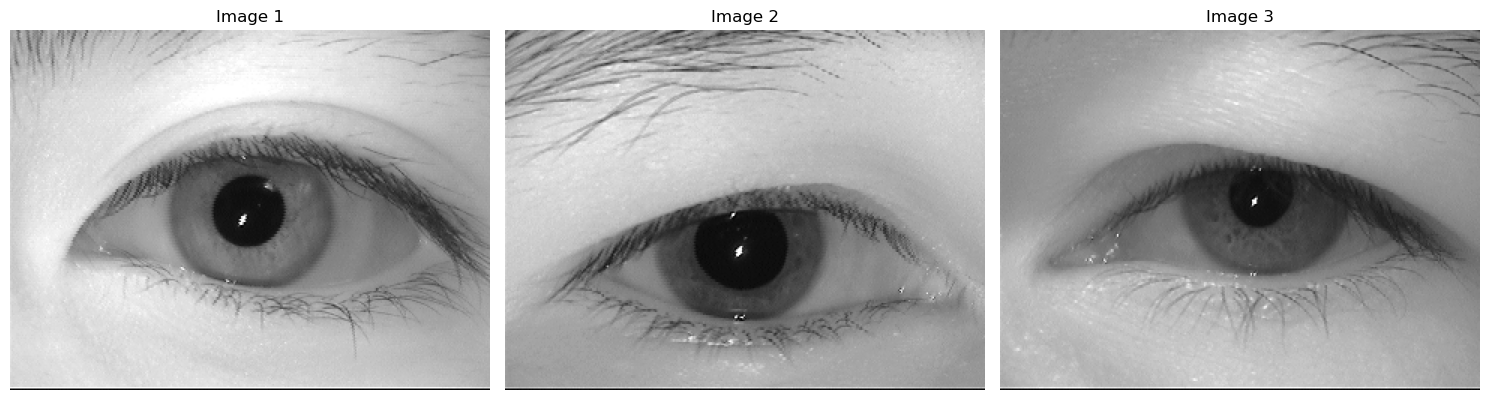

In [10]:
sample_images = data['image'].sample(3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#displaying sample images
for i, ax in enumerate(axes):
    ax.imshow(sample_images.iloc[i], cmap='gray')
    ax.axis('off') 
    ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

#### Converting all images to grayscale

In [11]:
data['image'] = data['image'].apply(lambda x: convert_to_grayscale(x))

# Pupil detection

#### Binarization of pupil experiments

binarization for x_i: 1.0


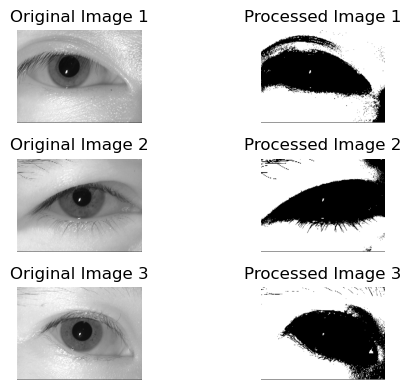

binarization for x_i: 2.0


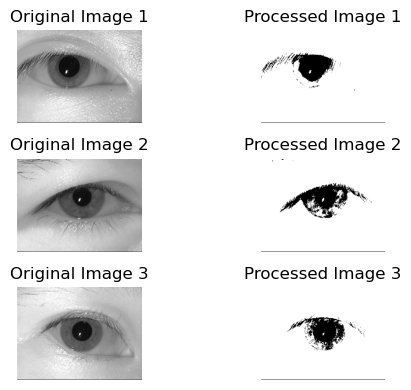

binarization for x_i: 3.0


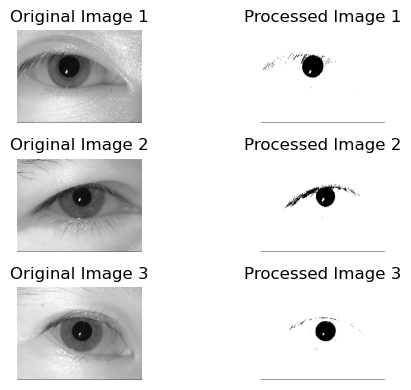

binarization for x_i: 4.0


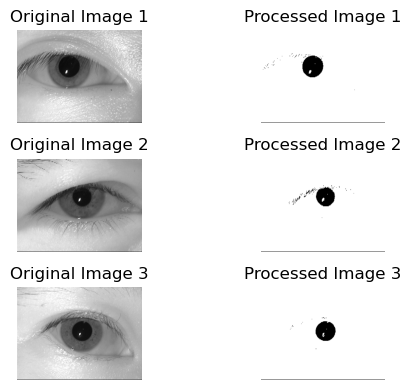

binarization for x_i: 5.0


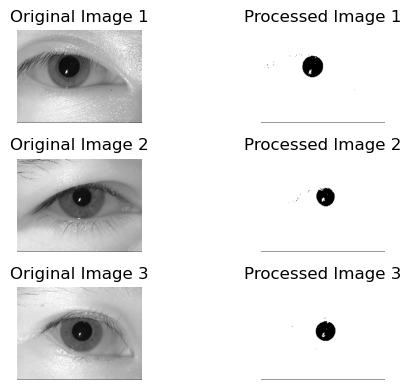

binarization for x_i: 6.0


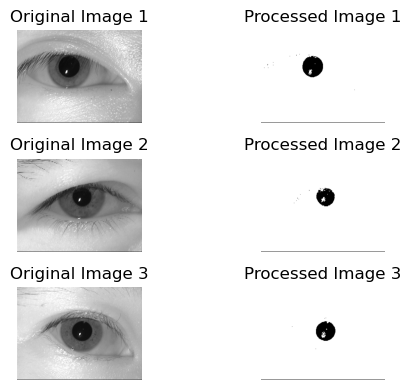

binarization for x_i: 7.0


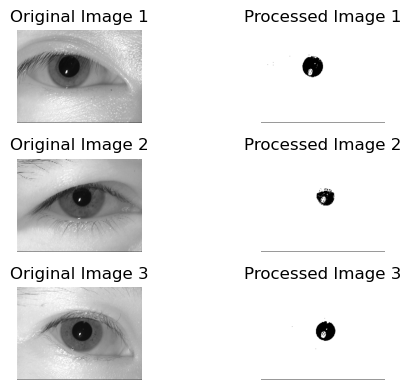

binarization for x_i: 8.0


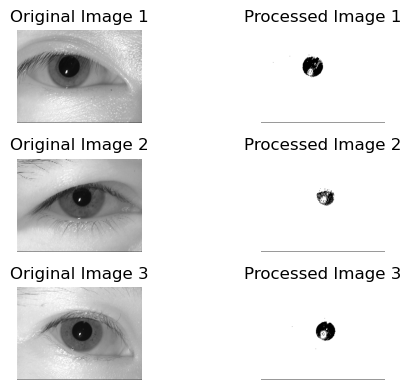

binarization for x_i: 9.0


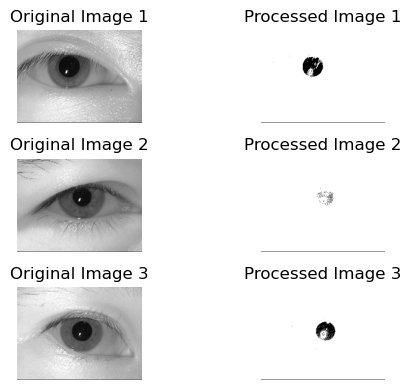

binarization for x_i: 10.0


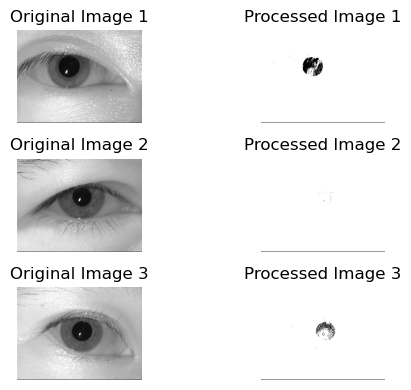

In [305]:
X_I=np.linspace(1,10,10)
sample_images = data['image'].sample(3)
for x_i in X_I:
    print('binarization for x_i:', x_i)
    processed_images = sample_images.apply(lambda x: pupil_binarization(x, x_i))
    plot_images_experiments(sample_images, processed_images, n=3)

Empirical results suggest that the optimal value for X_I lies within the range [3, 6]. We will explore this range:

binarization for x_i: 3.00


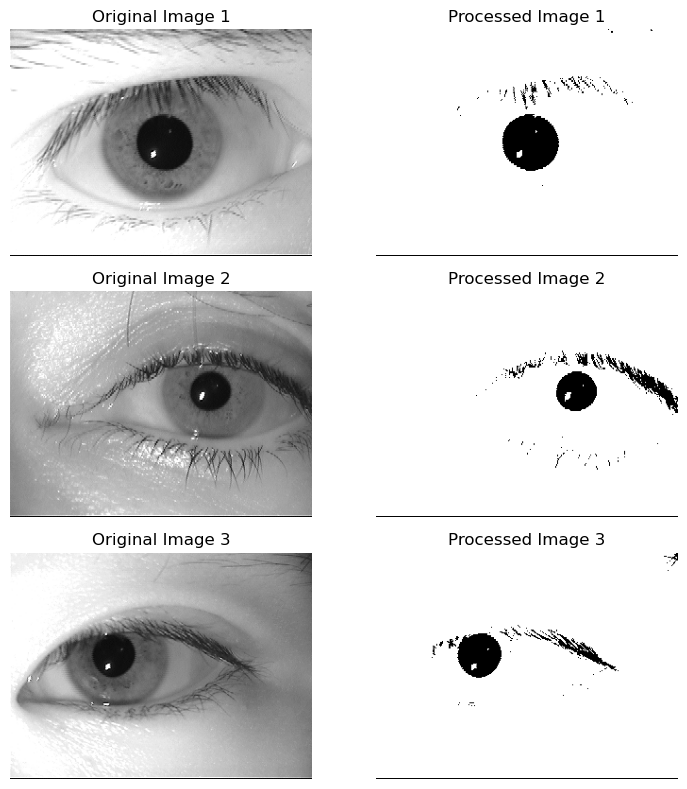

binarization for x_i: 4.00


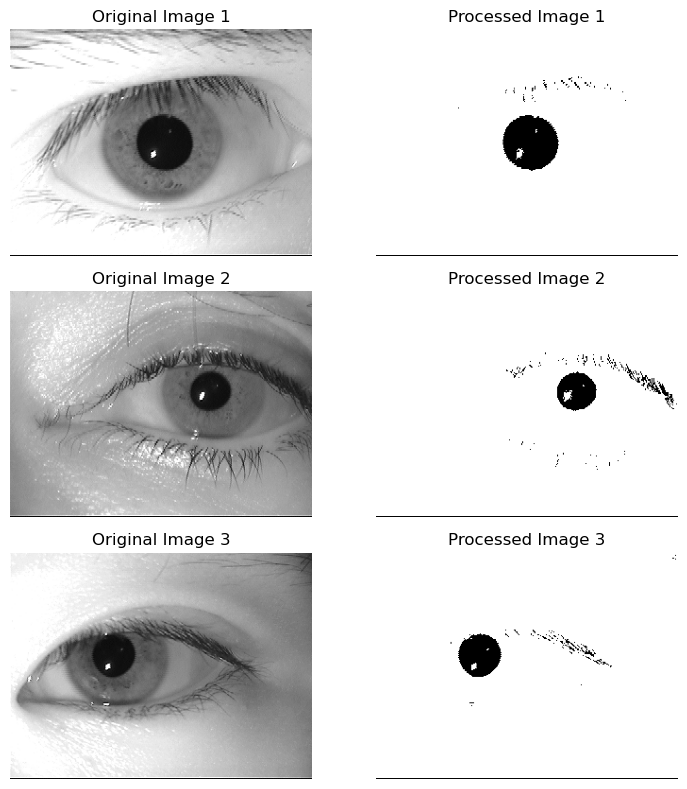

binarization for x_i: 5.00


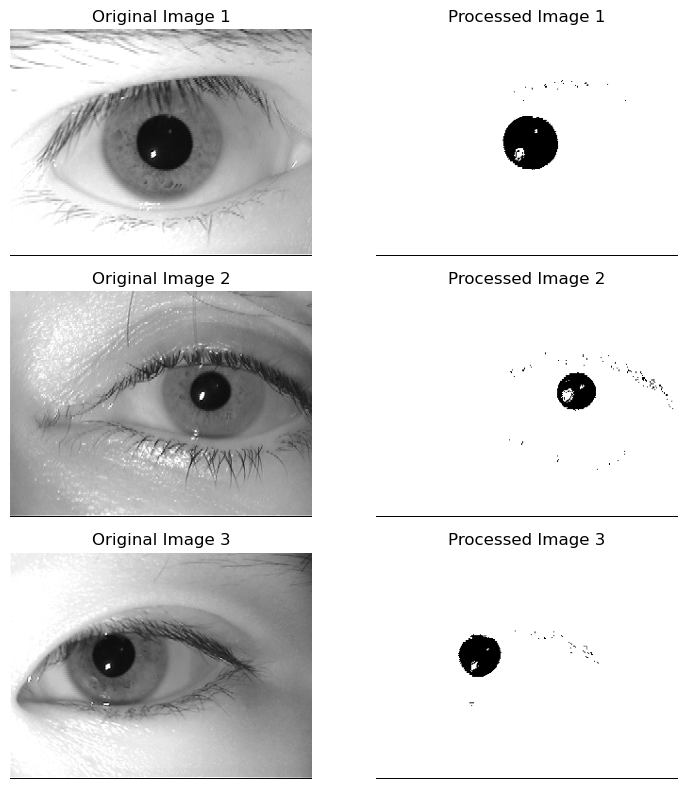

In [13]:
X_I = np.arange(3, 6, 1)
sample_images = data['image'].sample(3)
for x_i in X_I:
    print(f"binarization for x_i: {x_i:.2f}")
    processed_images = sample_images.apply(lambda x: pupil_binarization(x, x_i))
    plot_images_experiments(sample_images, processed_images, n=3, figsize=(8,8))

With thresholds:
* 3 - you can see lashes, not enough
* 4 and 5 much better
Let's experiment and find threhold between 4 and 5

binarization for x_i: 4.50


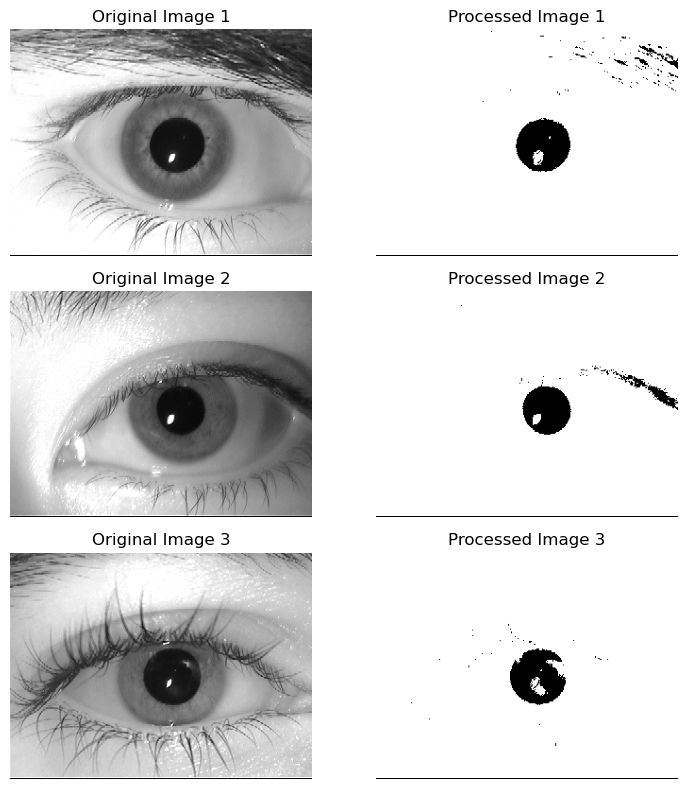

binarization for x_i: 4.60


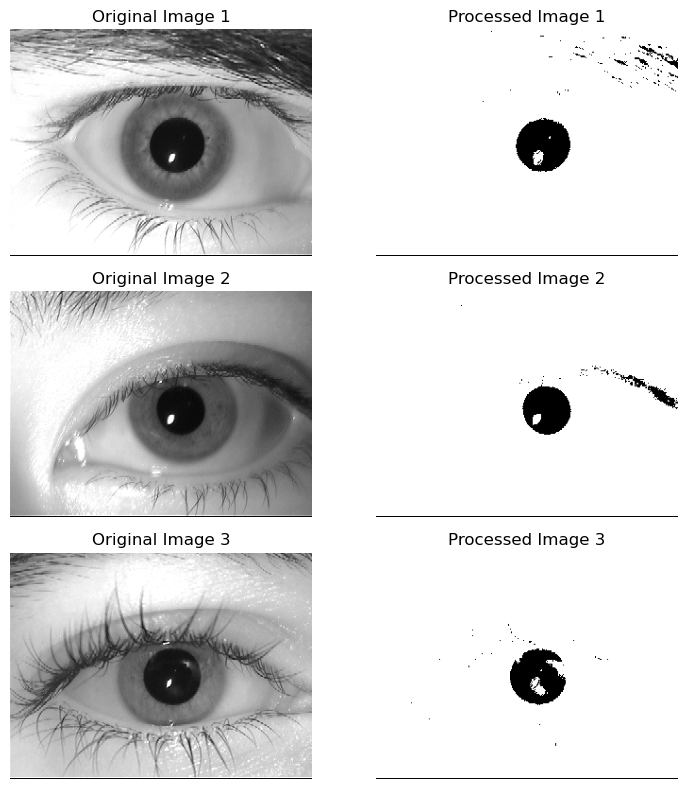

binarization for x_i: 4.70


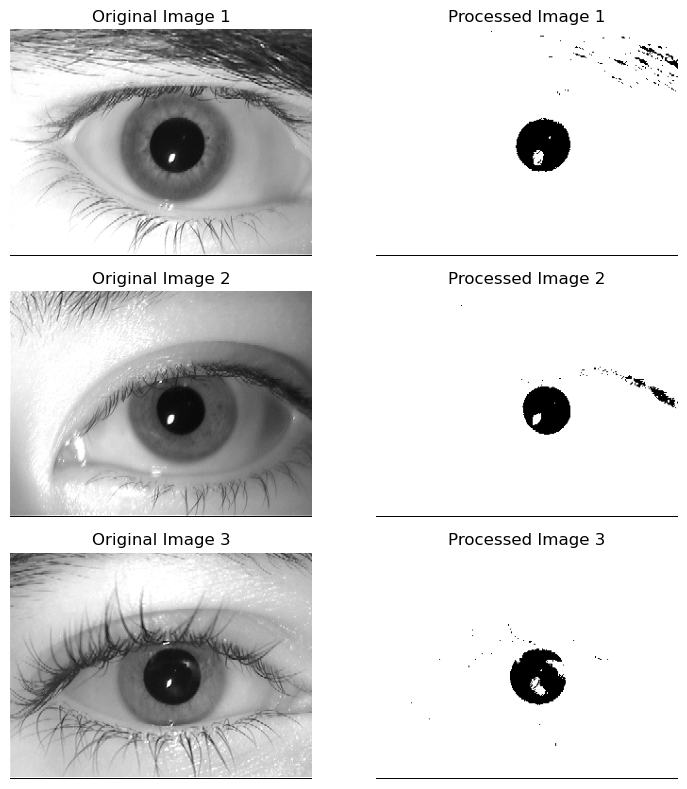

binarization for x_i: 4.80


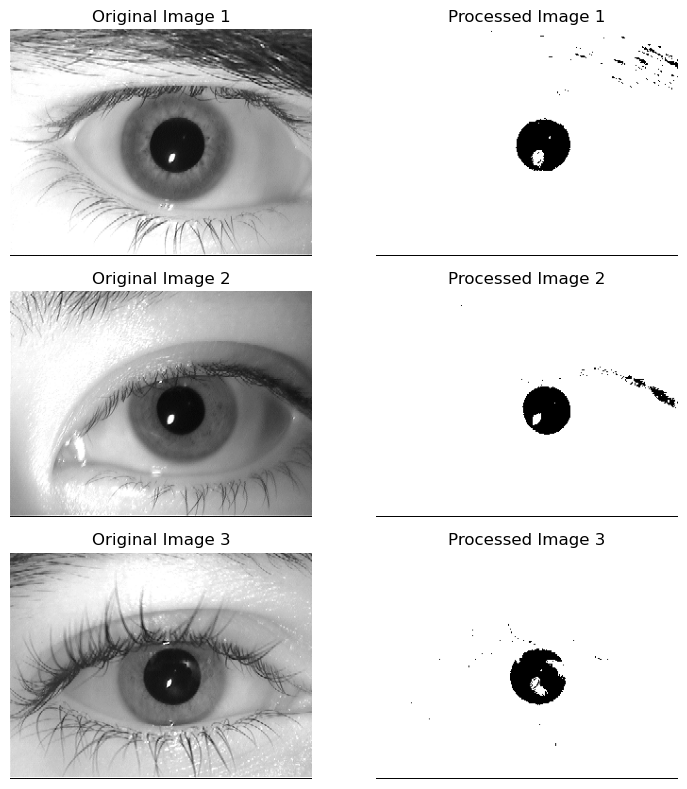

binarization for x_i: 4.90


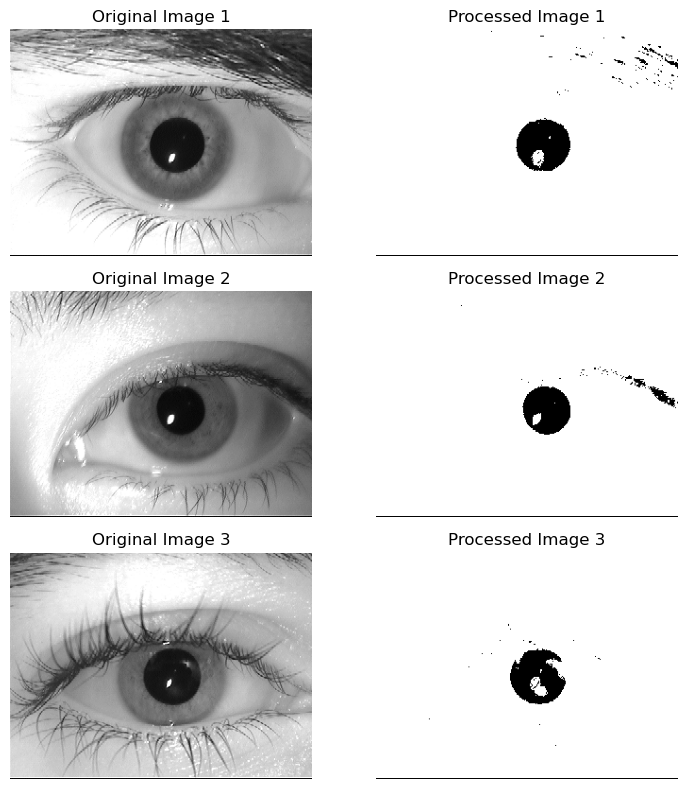

binarization for x_i: 5.00


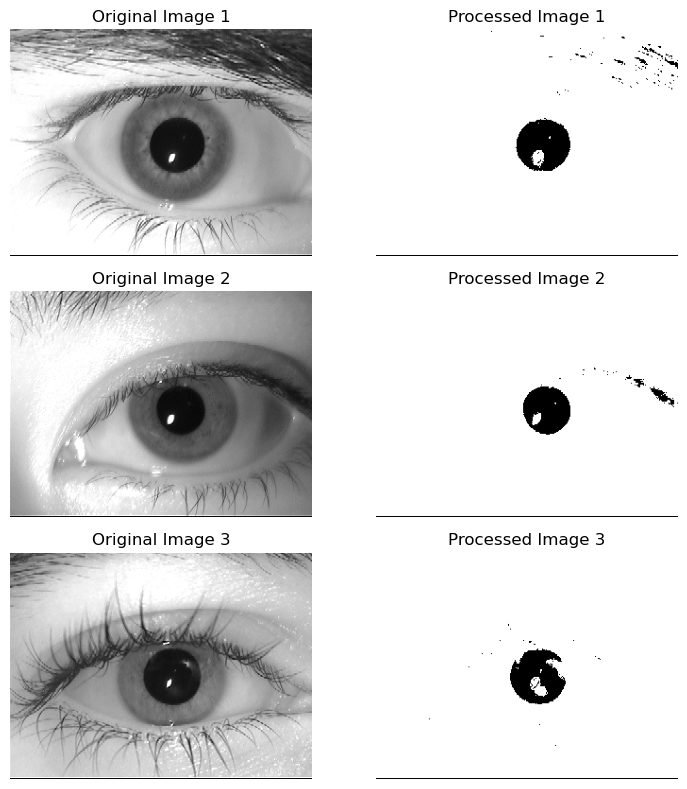

binarization for x_i: 5.10


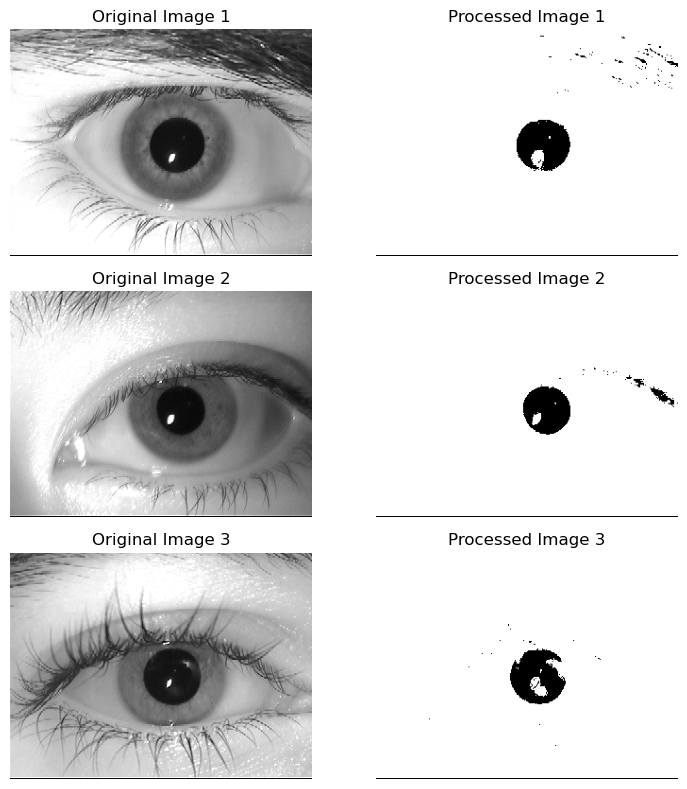

binarization for x_i: 5.20


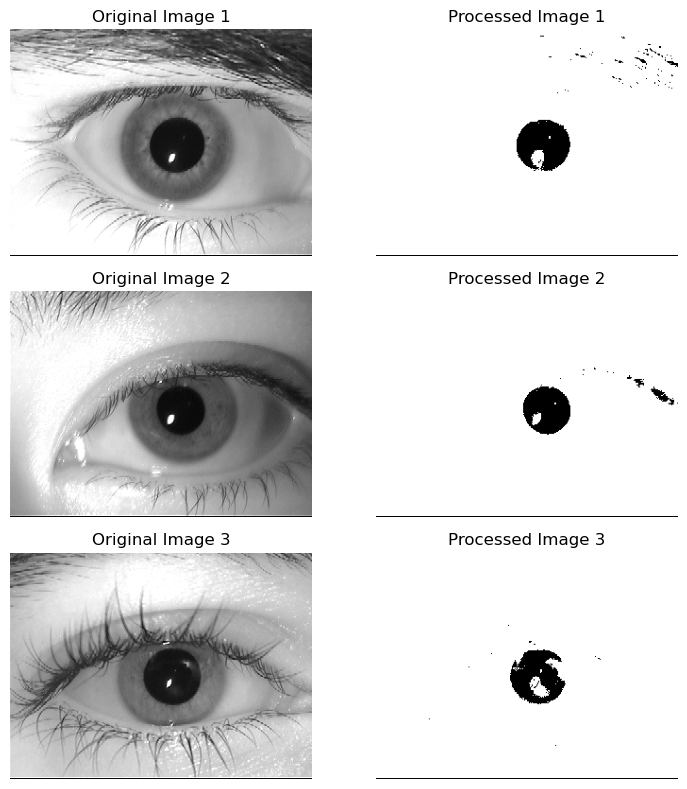

binarization for x_i: 5.30


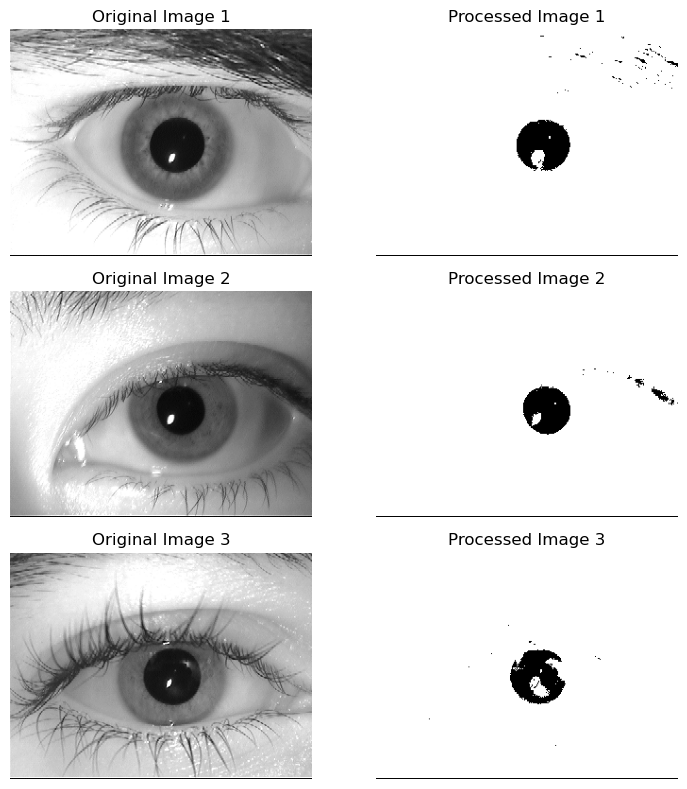

binarization for x_i: 5.40


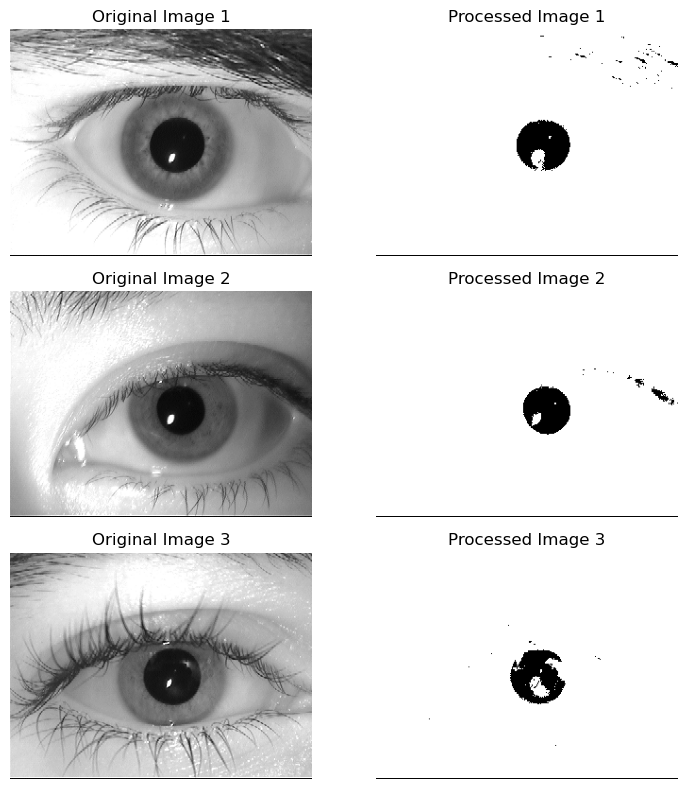

In [14]:
X_I = np.arange(4.5, 5.5, 0.1)
sample_images = data['image'].sample(3)
for x_i in X_I:
    print(f"binarization for x_i: {x_i:.2f}")
    processed_images = sample_images.apply(lambda x: pupil_binarization(x, x_i))
    plot_images_experiments(sample_images, processed_images, n=3, figsize=(8,8))

All threshold values are pretty ok. We will further investigate them with morphology.

## After morphology

After some experiments we chose threshold 5.2 as it worked best in most cases. Now it's time to find appropriate kernel sizes:

binarization for x_i: 5.20


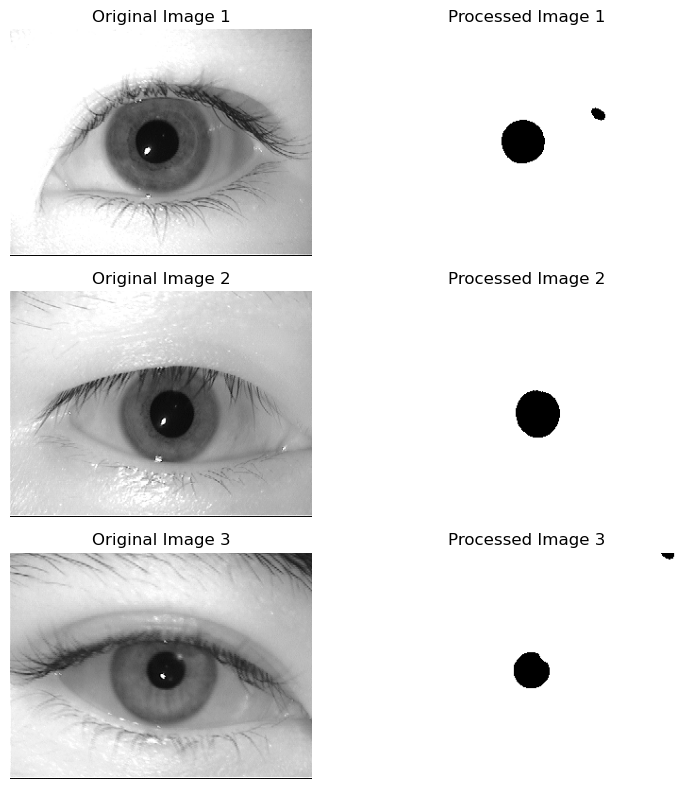

binarization for x_i: 5.20


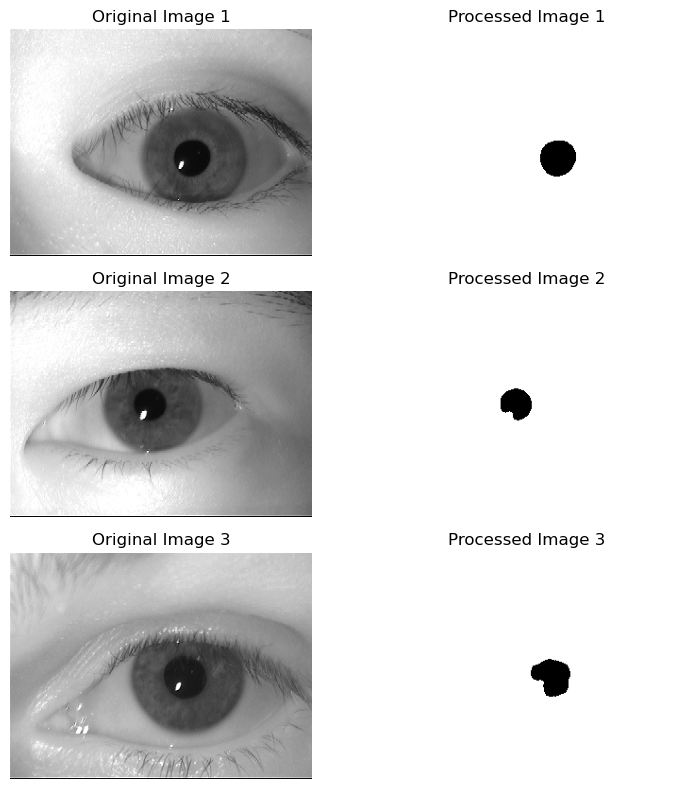

binarization for x_i: 5.20


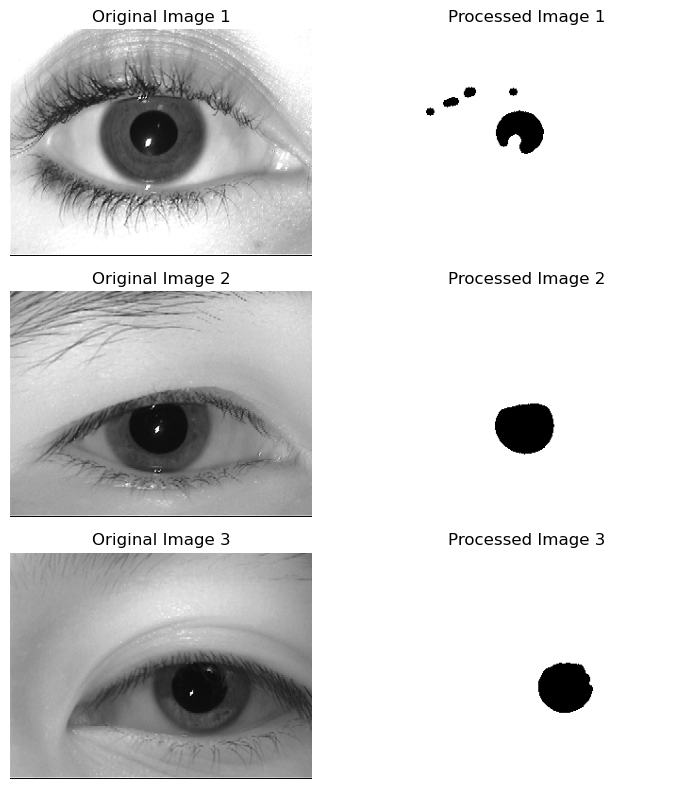

In [19]:
for i in range(3):
    sample_images = data['image'].sample(3)
    x_i = 5.2
    print(f"binarization for x_i: {x_i:.2f}")
    processed_images = sample_images.apply(lambda x: clean_pupil(x, x_i, open_kernel_size=7, close_kernel_size=9))
    plot_images_experiments(sample_images, processed_images, n=3, figsize=(8,8))

We can still see white dots and not so clear edges - lets increase closing kernel </br>
**Final results** after experimenting

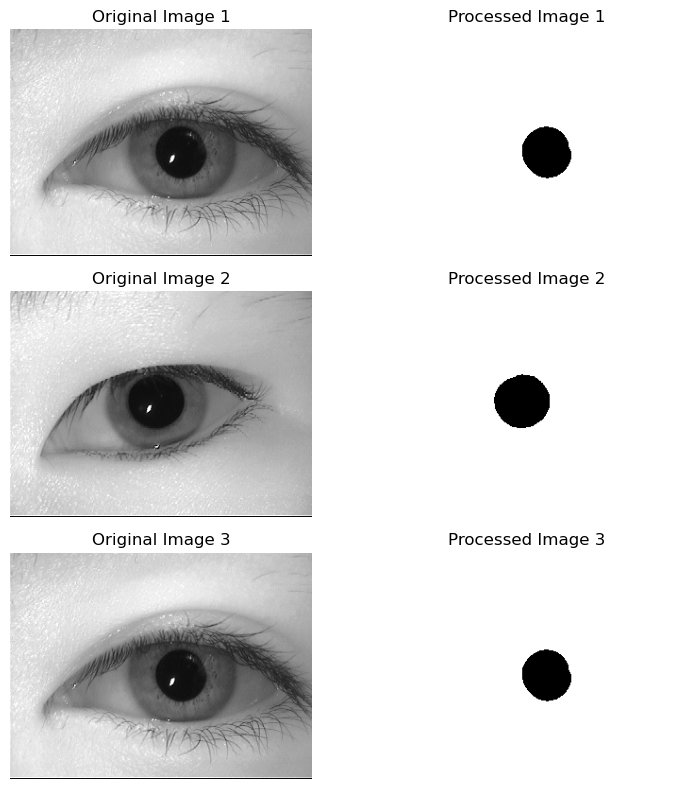

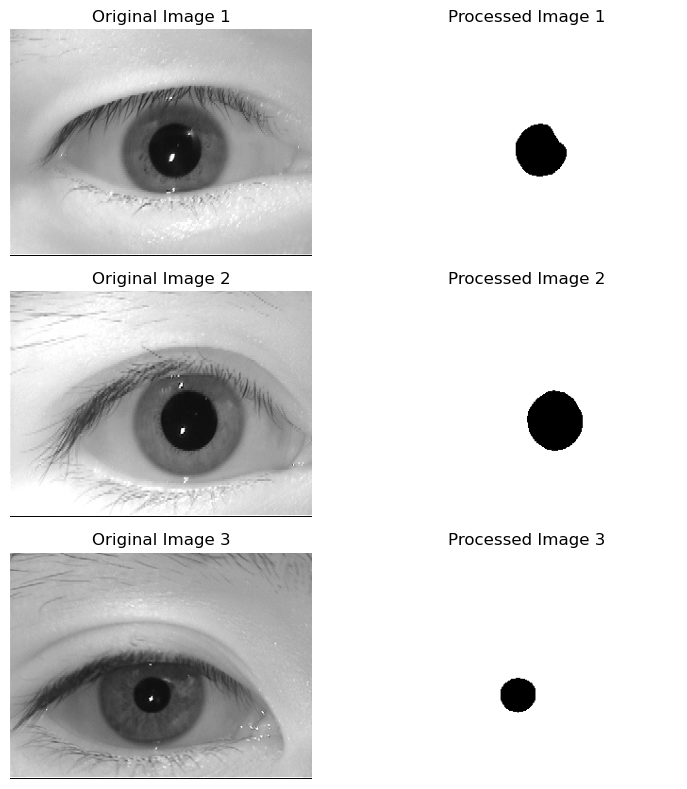

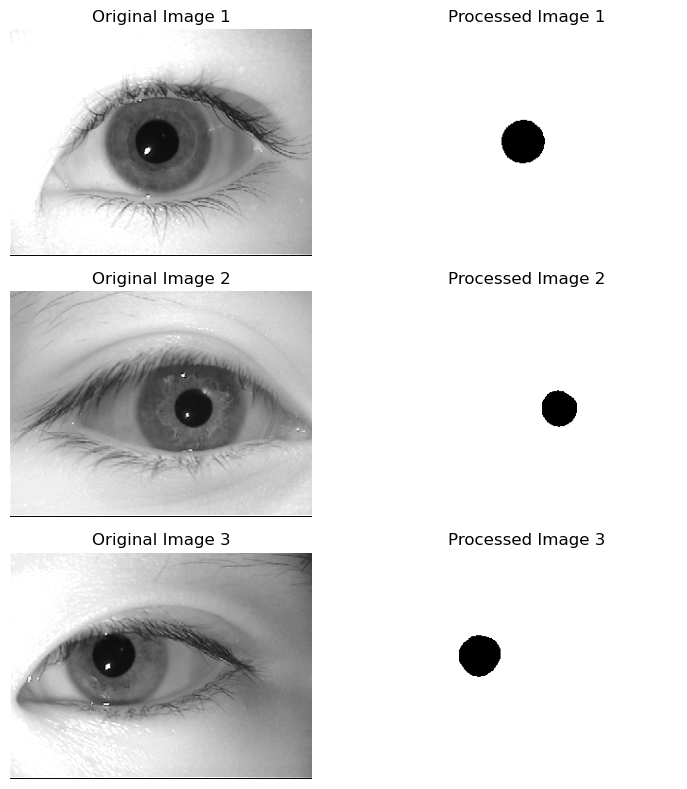

In [23]:
for i in range(3):
    sample_images = data['image'].sample(3)
    x_i = 5.2
    processed_images = sample_images.apply(lambda x: clean_pupil(x, x_i, open_kernel_size=9, close_kernel_size=23))
    plot_images_experiments(sample_images, processed_images, n = 3, figsize=(8,8))

Works well with most images. So final parameters are: </br>
</br>
Threshold : 5.2 </br>
Opening kernel size : 9 </br>
Closing kernel size : 23 </br>

## Center and radius

Projections method results:

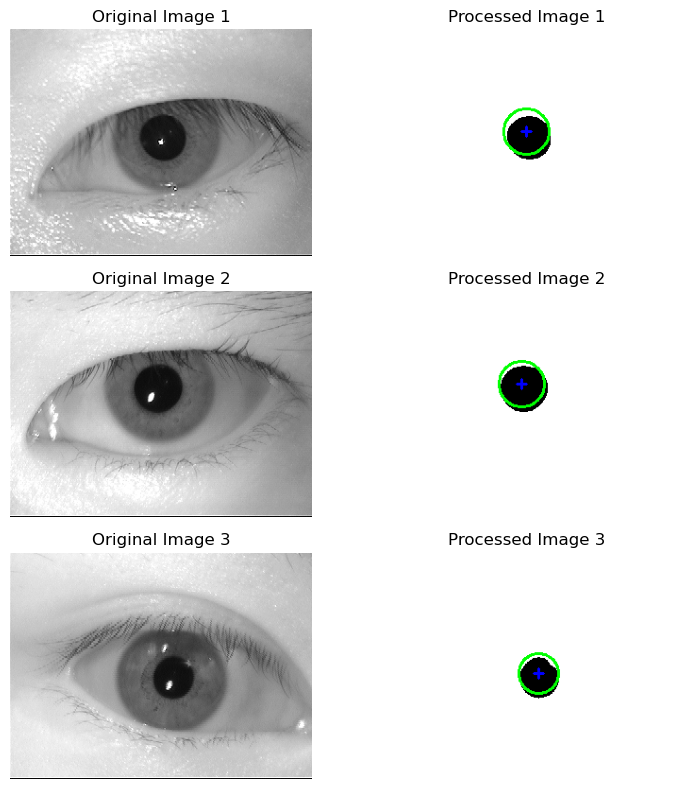

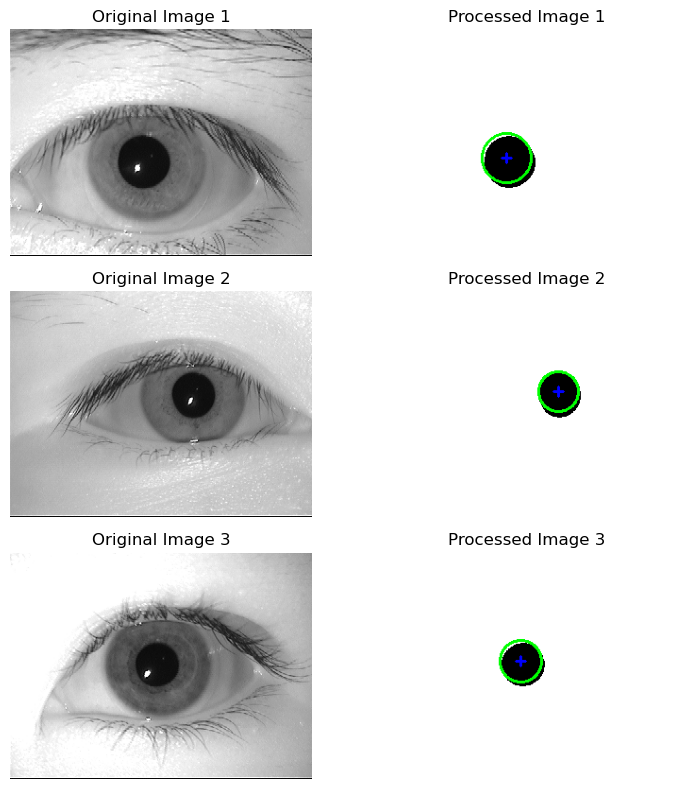

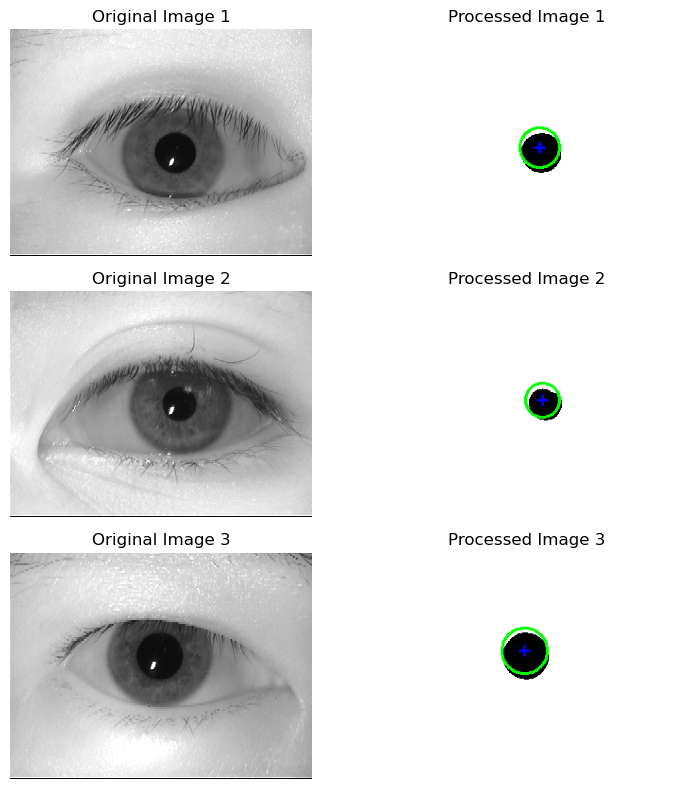

In [25]:
for i in range(3):
    sample_images = data['image'].sample(3)
    x_i = 5.2
    processed_images = sample_images.apply(lambda x: clean_pupil(x, x_i, open_kernel_size=9, close_kernel_size=23))
    centers = []
    radii = []
    images_cicle = []
    for img in processed_images:
        center, radius = pupil_center_radius(img)
        centers.append(center)
        radii.append(radius)
        img_with_circle = draw_pupil_circle(img.copy(), center, int(radius))
        images_cicle.append(img_with_circle)
    
    images_with_circles_series = pd.Series(images_cicle)
    
    plot_images_experiments(sample_images, images_with_circles_series, n=3, figsize=(8,8))

Method is not perfect but performs quite ok. We can see that often the middle is not exaclty where it is supposed to be, so we tried another center detection method.

## Moments center and radius

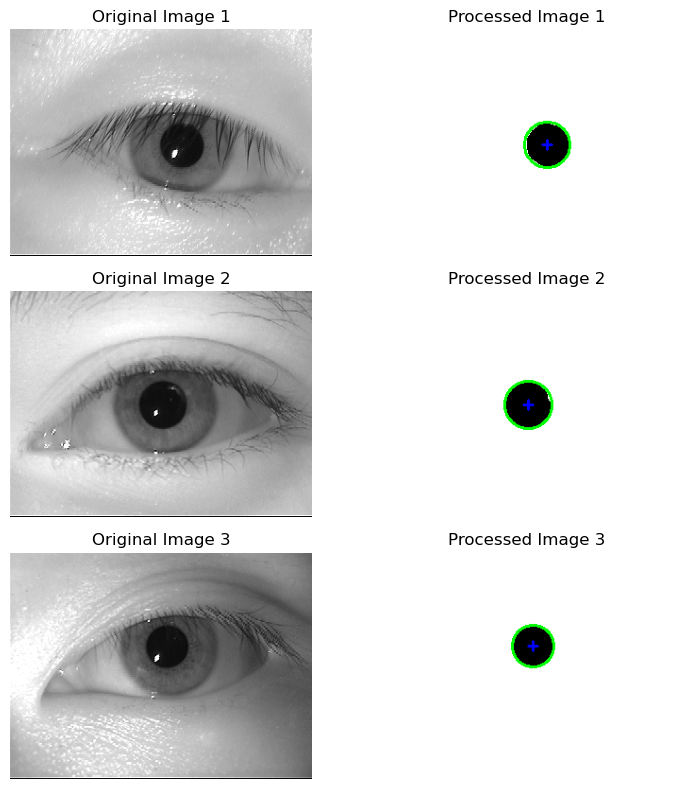

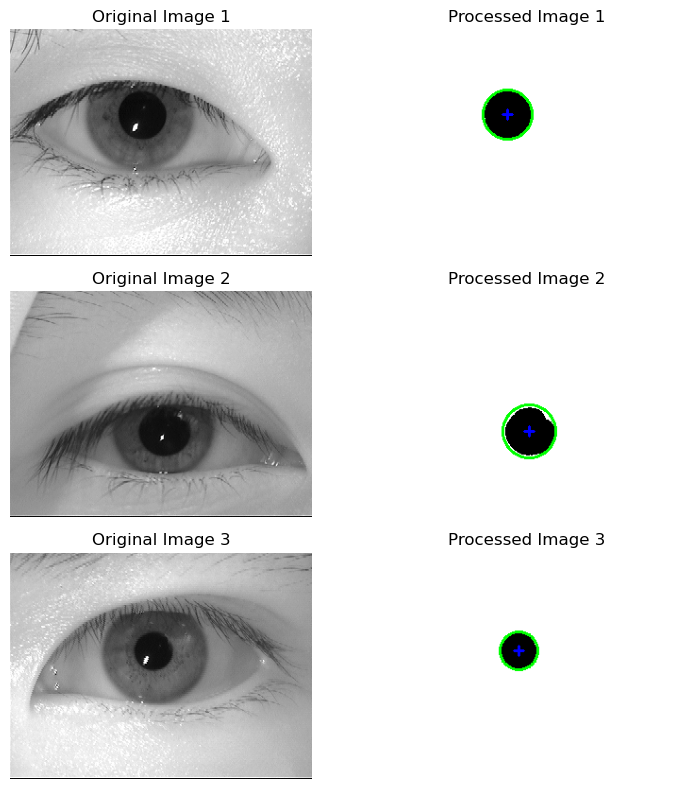

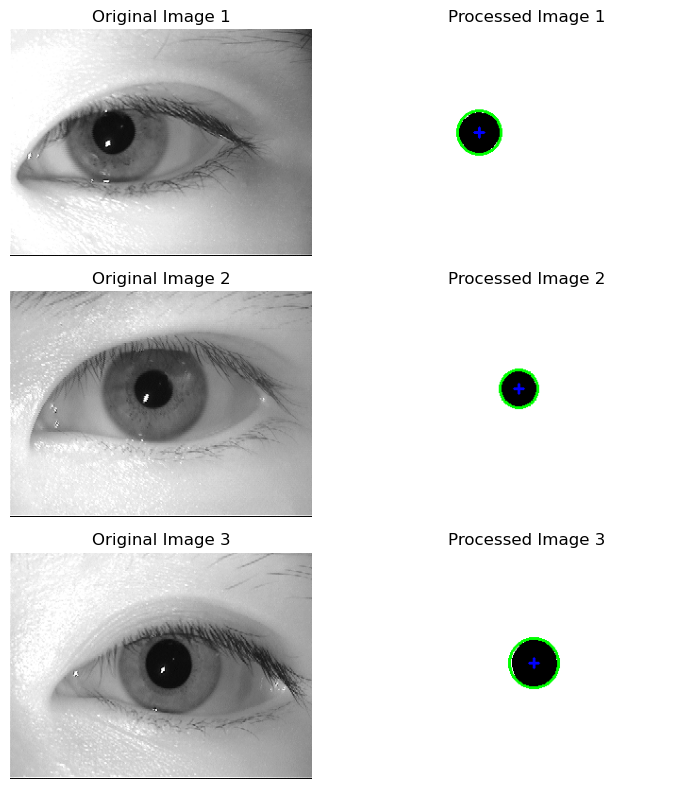

In [29]:
for i in range(3):
    sample_images = data['image'].sample(3)
    x_i = 5.2
    processed_images = sample_images.apply(lambda x: clean_pupil(x, x_i, open_kernel_size=9, close_kernel_size=23))
    centers = []
    radii = []
    images_cicle = []
    for img in processed_images:
        center, radius = pupil_center_radius_moments(img)
        centers.append(center)
        radii.append(radius)
        img_with_circle = draw_pupil_circle(img.copy(), center, int(radius))
        images_cicle.append(img_with_circle)
    
    images_with_circles_series = pd.Series(images_cicle)
    plot_images_experiments(sample_images, images_with_circles_series, n=3, figsize=(8,8))

Momentum method performs much better at finding center than projection. Radius is ok in both methods but now we can see an almost perfect match.